**24-08-22:** 
* Added height data. 
* Analysis on draft position by playing position

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_colwidth", 200)

### Importing csv files

In [2]:
df_nba = pd.read_csv('02_database/nba_player.csv')
df_ncaa = pd.read_csv('02_database/cbb_player.csv')
df_player_id = pd.read_csv('02_database/player_id_lookup.csv').drop_duplicates()## address this
df_nba_stats = pd.read_csv('02_database/nba_player_stats.csv')
df_cbb_stats = pd.read_csv('02_database/cbb_player_stats.csv')
df_cbb_career = pd.read_csv('02_database/cbb_player_career_stats.csv')
# this is the one main award lookup table. Don't need any other look up table
award_lookup_main = pd.read_csv('cbb_award_lookup_main.csv')

# award_lookup= pd.read_csv('02_database/award_lookup.csv')
df_ncaa_awards = pd.read_csv('02_database/cbb_player_awards.csv')

# df_award_year_start_end = pd.read_csv('02_database/award_year_start_end.csv')
# df_cbb_school = pd.read_csv('02_database/cbb_player_school.csv')
draft = pd.read_csv('02_database/nba_draft_bbref.csv')
df_cbb_height = pd.read_csv('02_database/cbb_player_height_weight.csv')
df_cbb_height = df_cbb_height.drop_duplicates() # not sure why there are duplicates

# # draft data
# draft_realgm = pd.read_csv('02_database/nba_draft_realgm.csv')
# # fixing mistakes 
# # these are the only ones that seems to be wrong
# draft_realgm.loc[draft_realgm.Player.isin(['Pierre Jackson','James Ennis','Bernard James','Jae Crowder','Cleanthony Early']),['Class']] = 'So'
# draft_realgm.loc[draft_realgm.Player.isin(['Carrick Felix','Darius Johnson-Odom','Josh Harrellson']),['Class']] = 'Jr'
# draft_realgm.Class.fillna(value='other',inplace = True)

# # altering awards table to inlude only Conferece awards and select National Awards -- what about All america and All NCAA?
# x = df_ncaa_awards.merge(df_award_year_start_end, how = 'left',left_on = 'award_name',right_on = 'award_name')
# df_ncaa_awards = x.loc[(x.use_for_analysis == 1)|(x.award_type.isin(['conference','NCAA Tournament All-Region','Consensus All-America'])),list(df_ncaa_awards.columns)+['short_name']]
# df_ncaa_awards.loc[df_ncaa_awards.award_type=='NCAA Tournament All-Region',['short_name']] = 'ncaa_t_all_reg'
# df_ncaa_awards.loc[df_ncaa_awards.award_type=='Consensus All-America',['short_name']] = 'all_amer'
# df_ncaa_awards.loc[df_ncaa_awards.award_type=='conference',['short_name']] = 'conference'



#### Create table `cbb_playing_tenure`  
Table containing the total_seasons for each player

In [3]:
cbb_playing_tenure = df_cbb_stats.loc[:,['season','conference','player_id']]
cbb_playing_tenure['year_p1'] =  cbb_playing_tenure.season.str.split('-', expand = True)[0]
cbb_playing_tenure['year_p2'] =  str(20)+ cbb_playing_tenure.season.str.split('-', expand = True)[1]

# first_year, last_year example:
# player1:
# 2010-2011
# 2011-2012
# 2012-2013
# first_year = 2010
# last_year = 2012
cbb_playing_tenure = cbb_playing_tenure.groupby(['player_id']).agg(
    first_year = ('year_p1','min'),
    last_year = ('year_p1','max'),
    no_conf = ('conference','nunique'),
    total_seasons = ('season','count')
)

cbb_playing_tenure['first_year'] = cbb_playing_tenure['first_year'].astype(int)
cbb_playing_tenure['last_year'] = cbb_playing_tenure['last_year'].astype(int)


# players who have total_season >4 have played just 4 years but data will show longer due to transfers and sitting out
cbb_playing_tenure.loc[cbb_playing_tenure.total_seasons>4,'total_seasons'] =4

cbb_playing_tenure.head(2)

,first_year,last_year,no_conf,total_seasons
player_id,,,,
aakim-saintil-1,2013,2015,2,2
aalim-moor-1,2009,2012,1,4


#### Creating table `main_conf`
Some players will play in multiple conferences, for those cases I will take their main conference as one where they played most games.  
If player played the same number of games in multiple conferences, I will just pick the first one on the list

In [4]:
# player conference is one where he played most games
games_per_conf = df_cbb_stats.loc[:,['player_id','season','conference','games_played']].groupby(['player_id','conference'])['games_played'].sum()
conf_rank = games_per_conf.groupby(level=0).rank(method = 'first',ascending = False).reset_index().sort_values(['player_id','games_played'])
main_conf = conf_rank.loc[conf_rank.games_played == 1,['player_id','conference']]
main_conf.head(3)

,player_id,conference
0,aakim-saintil-1,northeast
2,aalim-moor-1,wac
3,aamahd-walker-1,big-west


### Creating single table to summarise collegian player career

In [5]:
df = df_ncaa.merge(df_player_id[['nba_player_id','cbb_player_id']], how = 'left', left_on = 'player_id',right_on = 'cbb_player_id',indicator= 'in_nba' )
df.drop(columns = ['cbb_player_id'],inplace = True)
df.rename(columns = {'player_id':'cbb_player_id'},inplace = True)
df = df.set_index('cbb_player_id').merge(cbb_playing_tenure, how = 'left',left_index = True,right_index= True)

# merge df_ncaa_awards with award_lookup and df
x = df_ncaa_awards.merge(award_lookup_main, how='left', left_on='award_name',right_on='award_name')\
.loc[:,['player_id', 'award_orig_name','award_name','award_category_l1', 'award_category_l2','award_category_l3' ,'conf_abbr', 'conf_full','short_name','award_year_main', 'use_for_analysis']]
x = x[x.use_for_analysis == 1]
df = df.reset_index().merge(x, how = 'left', left_on = 'cbb_player_id', right_on = 'player_id')

# convert in_nba to flag
df['in_nba']= df.in_nba.cat.rename_categories({'left_only':0,'both':1})
df['in_nba'] = df.in_nba.cat.remove_categories('right_only')
df['in_nba'] = df.in_nba.astype(int) # categorical var show unused categories, which I dont want


# add main conference
df = df.merge(main_conf, how = 'inner', left_on = 'cbb_player_id', right_on = 'player_id')
df.drop(columns = ['player_id_y','player_id_x'],inplace = True)

# merge with draft data
df = df.merge(draft, how = 'left', left_on='nba_player_id', right_on = 'nba_player_id')
df.drop(columns = ['team','college','link','player_name'],inplace = True)

# add class variable (fr, so, jr, sr)
df.loc[(df.in_nba==1)&(~df.pick.isna())&(df.total_seasons == 1),['d_class']] = 'fr'
df.loc[(df.in_nba==1)&(~df.pick.isna())&(df.total_seasons == 2),['d_class']] = 'so'
df.loc[(df.in_nba==1)&(~df.pick.isna())&(df.total_seasons == 3),['d_class']] = 'jr'
df.loc[(df.in_nba==1)&(~df.pick.isna())&(df.total_seasons > 3),['d_class']] = 'sr'

# merge with height data
df = df.merge(df_cbb_height.loc[:,['cbb_player_id','height_cm']], how = 'left', left_on = 'cbb_player_id', right_on = 'cbb_player_id')

# add main conference
df = df.merge(main_conf,how = 'inner',left_on='cbb_player_id', right_on='player_id' ).rename(columns = {'conference_y':'main_conf'}).drop(columns = ['conference_x','player_id'])

# adding award_year flags
# for award purposes, first year of award is first_year+1 and last year is last_year+1
# might not work so well when there are transfers
df['award_yr_fr'] = np.where((df.total_seasons>=1) & (df.award_year_main == df.first_year.astype(int)+1),df.first_year.astype(int)+1,np.nan)
df['award_yr_so'] = np.where((df.total_seasons>=2) & (df.award_year_main == df.first_year.astype(int)+2),df.first_year.astype(int)+2,np.nan)
df['award_yr_jr'] = np.where((df.total_seasons>=3) & (df.award_year_main == df.first_year.astype(int)+3),df.first_year.astype(int)+3,np.nan)
df['award_yr_sr'] = np.where((df.total_seasons==4) & (df.award_year_main == df.first_year.astype(int)+4),df.first_year.astype(int)+4,np.nan)

## creating flag twice - once here then using it to identify instances where above code didn't work because of transfers.
# adding award_year flag, 1/0 depending which class the award was won
df['award_yr_fr_flag'] = np.where(~df.award_yr_fr.isna(),1,0)
df['award_yr_so_flag'] = np.where(~df.award_yr_so.isna(),1,0)
df['award_yr_jr_flag'] = np.where(~df.award_yr_jr.isna(),1,0)
df['award_yr_sr_flag'] = np.where(~df.award_yr_sr.isna(),1,0)

# all other award winners, set their awards in the final year
df.loc[(~df.award_name.isna())&(df.award_yr_fr_flag+df.award_yr_so_flag+df.award_yr_jr_flag+df.award_yr_sr_flag==0)&(df.total_seasons==2),['award_yr_so']] = df.award_year_main
df.loc[(~df.award_name.isna())&(df.award_yr_fr_flag+df.award_yr_so_flag+df.award_yr_jr_flag+df.award_yr_sr_flag==0)&(df.total_seasons==3),['award_yr_jr']] = df.award_year_main
df.loc[(~df.award_name.isna())&(df.award_yr_fr_flag+df.award_yr_so_flag+df.award_yr_jr_flag+df.award_yr_sr_flag==0)&(df.total_seasons==4),['award_yr_sr']] = df.award_year_main


# adding award_year flag, 1/0 depending which class the award was won
df['award_yr_fr_flag'] = np.where(~df.award_yr_fr.isna(),1,0)
df['award_yr_so_flag'] = np.where(~df.award_yr_so.isna(),1,0)
df['award_yr_jr_flag'] = np.where(~df.award_yr_jr.isna(),1,0)
df['award_yr_sr_flag'] = np.where(~df.award_yr_sr.isna(),1,0)


df['award_won_fist_year'] = np.where((pd.to_numeric(df.first_year)+1 == pd.to_numeric(df.award_year_main)),1,0)
df['award_won_last_year'] = np.where((pd.to_numeric(df.last_year)+1 == pd.to_numeric(df.award_year_main)),1,0)

# filtering the dataset to include seasons 2010-11 until 2018-19
df = df[(df.first_year >=2010) & (df.first_year <=2018)]

df.head(3)

,cbb_player_id,name,nba_player_id,in_nba,first_year,last_year,no_conf,total_seasons,award_orig_name,award_name,award_category_l1,award_category_l2,award_category_l3,conf_abbr,conf_full,short_name,award_year_main,use_for_analysis,pick,d_year,d_round,d_class,height_cm,main_conf,award_yr_fr,award_yr_so,award_yr_jr,award_yr_sr,award_yr_fr_flag,award_yr_so_flag,award_yr_jr_flag,award_yr_sr_flag,award_won_fist_year,award_won_last_year
0,harrison-hawkins-1,Harrison Hawkins,NaN,0,2013,2014,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,183.0,southland,NaN,NaN,NaN,NaN,0,0,0,0,0,0
1,parker-wentz-1,Parker Wentz,NaN,0,2013,2015,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,175.0,southland,NaN,NaN,NaN,NaN,0,0,0,0,0,0
2,ladarrien-williams-1,LaDarrien Williams,NaN,0,2013,2014,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,183.0,southland,NaN,NaN,NaN,NaN,0,0,0,0,0,0


### NEW ANALYSIS

#### Pick a collage to play for:
The most sure way to see NBA minutes is via the NBA Draft. During this annual event, the 60 players who get selected will have the best possible chance to see any NBA game time. Over the years from 2011 to 2019 an average of 80% are selected from a collegian program. The remaining 20% are international and those who chose to play for professional teams within USA. The exact rules that govern draft eligibility are not relevant for this analysis, but it's suffice to say that playing collage basketball will give you an edge. If you want to even participate in an NBA practice, you'll want any advantage you can get. 

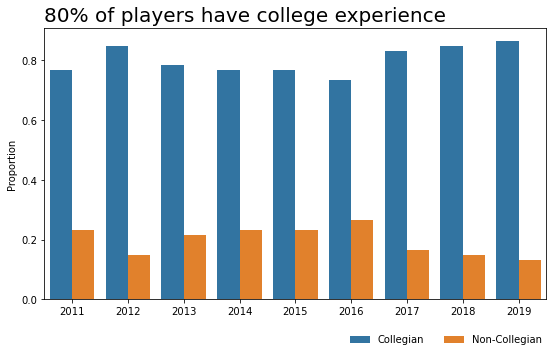

In [85]:
# 2010-11 until 2018-19
draft['player_type'] = np.where(draft.college.isna(),'Non-Collegian', 'Collegian')
x = draft[(draft.d_year>=2011)&(draft.d_year<=2019)].groupby(['d_year','player_type'])['player_name'].count().agg(
    {'PlayersDrafted':lambda x:x,'Prop':lambda x:x/x.groupby(level=0).sum() }
).unstack(level=0).reset_index()

plt.figure(figsize = (9,5))
g = sns.barplot(data = x, x = 'd_year',y = 'Prop', hue = 'player_type')
sns.move_legend(g, 'lower center', bbox_to_anchor = (.8,-.2), ncol=3, title = None, frameon = False)
g.set_xlabel('')
g.set_ylabel('Proportion')
g.set_title('80% of players have college experience', x = .4, fontsize = 20)
plt.show()

If you've decided to take the collegian route, the next step is to determine which college program is best suited for your talents. Across the USA there are over 1000 colleges divided into three divisions offering basketball programs, however if you're goal is NBA you'll need to play for a Division I program. Over the entire 75 year NBA history, less than 200 players had Division II college experience. Data on NBA players coming from Division III program is hard to get but it's safe to assume that one could could the number on one hand and still have some fingers left over.   

Once you've set your eyes on Div I program, you can further increase your chances by selecting the right conference. Division I is made up of approximately 350 schools divided into 32 conferences. However, over the 9 years from 2011-2019 80% of NBA players came from just 7 conferences.

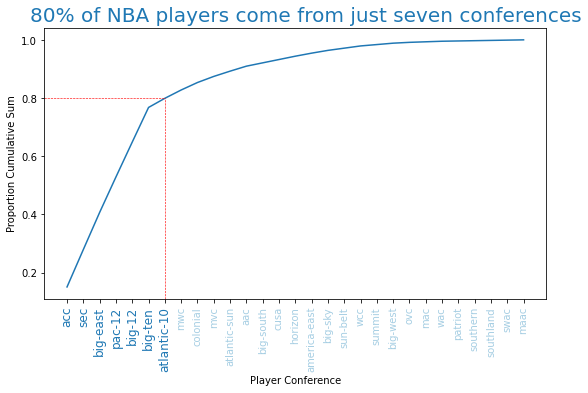

In [202]:
x = df[(df.in_nba==1)].groupby(['main_conf'])['cbb_player_id'].count().sort_values(ascending = False).agg(
    {'total':lambda x:x, 'prop':lambda x: x/x.sum(),'cumulative':lambda x: (x/x.sum()).cumsum()}
).unstack(level=0).reset_index()

plt.figure(figsize=(9,5))
g = sns.lineplot(data = x, x = 'main_conf', y = 'cumulative')
g.axvline(x = 6, ymax= 0.74, ls='--', color = 'red',lw = 0.6)
g.axhline(y = 0.8, xmax=.24, ls='--', color = 'red',lw = 0.6)
g.tick_params(axis='x', rotation=90)
g.set_xlabel('Player Conference')
g.set_ylabel('Proportion Cumulative Sum')
g.set_title('80% of NBA players come from just seven conferences'
            ,fontsize = 20
            ,color = sns.color_palette("Paired")[1]
           ,x = .52)
for val,label in enumerate(g.get_xticklabels()):
    if val<=6:
        label.set_color(sns.color_palette("Paired")[1])
        label.set_fontsize('12')
    else:
        label.set_color(sns.color_palette("Paired")[0])

One reason why 22% of Div I conferences have such a stronghold of NBA talent, is because some of the best players choose and get accepted into programs within these conferences. One way to identify great players is by looking at the type and the number of awards these player win.  
At a high level, the collegian awards can be divided into two main categories, individual awards and conference based awards. The former holds higher prestige because these awards are given to just 1 player (with some exceptions) across all basketball programs. The latter is given to players within each conference.  
For example, the much coveted Naismith Award can be won by just 1 player in year across all 1000+ schools. Where as the Big-Ten Player Of The Year (POY) award if given to the best player in the Big-Ten conference. A similar POY award can be worn by a different player in a another conference in the same year.  
Therefore, should you wish to boost your chances of playing in front of 15,000+ fans, try winning of the few Individual awards.  
In the next section, let's take a look at some of these awards and how they tie in with conferences and playing in the NBA.

## Awards - Analysis

In [217]:
df[~df.award_category_l1.isna()].head()

,cbb_player_id,name,nba_player_id,in_nba,first_year,last_year,no_conf,total_seasons,award_orig_name,award_name,award_category_l1,award_category_l2,award_category_l3,conf_abbr,conf_full,short_name,award_year_main,use_for_analysis,pick,d_year,d_round,d_class,height_cm,main_conf,award_yr_fr,award_yr_so,award_yr_jr,award_yr_sr,award_yr_fr_flag,award_yr_so_flag,award_yr_jr_flag,award_yr_sr_flag,award_won_fist_year,award_won_last_year
11,kj-maura-1,K.J. Maura,NaN,0,2014,2017,2,3,2017-18 AEC Defensive Player of the Year,AEC Defensive Player of the Year,Conference Award,DPOY,Conference,AEC,America East Conference,NaN,2018.0,1.0,NaN,NaN,NaN,NaN,170.0,america-east,NaN,NaN,2018.0,NaN,0,0,1,0,0,1
12,kj-maura-1,K.J. Maura,NaN,0,2014,2017,2,3,2017-18 All-AEC - 3rd Team,All-AEC,Conference Award,All-Conf,Conference,AEC,America East Conference,NaN,2018.0,1.0,NaN,NaN,NaN,NaN,170.0,america-east,NaN,NaN,2018.0,NaN,0,0,1,0,0,1
20,matt-mooney-1,Matt Mooney,moonema01,1,2014,2018,3,4,2018-19 All-Big 12 - 2nd Team,All-Big 12,Conference Award,All-Conf,Conference,Big 12,Big 12 Conference,NaN,2019.0,1.0,NaN,NaN,NaN,NaN,190.0,summit,NaN,NaN,NaN,2019.0,0,0,0,1,0,1
21,matt-mooney-1,Matt Mooney,moonema01,1,2014,2018,3,4,2019 NCAA All-Tournament,NCAA All-Tournament,National Award,Individual,Individual,usa,usa,ncaa_all_t,2019.0,1.0,NaN,NaN,NaN,NaN,190.0,summit,NaN,NaN,NaN,2019.0,0,0,0,1,0,1
22,matt-mooney-1,Matt Mooney,moonema01,1,2014,2018,3,4,2019 NCAA Tournament All-Region,NCAA Tournament All-Region,NCAA Tournament All-Region Team,Individual,Individual,usa,usa,NaN,2019.0,1.0,NaN,NaN,NaN,NaN,190.0,summit,NaN,NaN,NaN,2019.0,0,0,0,1,0,1


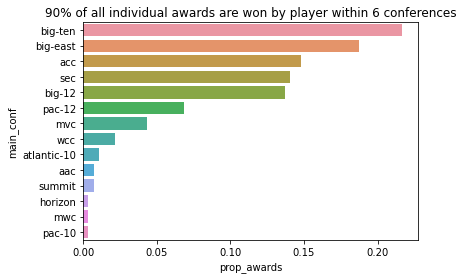

In [228]:
x = df[df.award_category_l3=='Individual'].groupby(['main_conf'])['award_name'].count().sort_values(ascending = False).agg(
    {'total_awards':lambda x:x, 'prop_awards':lambda x: x/x.sum(), 'cumsum': lambda x: (x/x.sum()).cumsum()}
).unstack(level = 0).reset_index()

g = sns.barplot(data = x, x = 'prop_awards', y = 'main_conf')
g.set_title("90% of all individual awards are won by player within 6 conferences")
plt.show()

Let's look at it from another angle. What if you do not play for any of the top 6 conferences, is there a particular award you could aim for that could boost your chances for an NBA roster spot?

In [235]:
x = df[df.award_category_l3=='Individual'].groupby(['award_name','in_nba'])['cbb_player_id'].count().agg(
    {'total_players':lambda x:x, 'prop_players':lambda x: x/x.groupby(level=0).sum()}
).unstack(level=0).reset_index()
x.head()

,award_name,in_nba,total_players,prop_players
0,AP Player of the Year,1,7.0,1.000000
1,Consensus All-America,0,8.0,0.129032
2,Consensus All-America,1,54.0,0.870968
3,NABC Defensive Player of the Year,0,1.0,0.142857
4,NABC Defensive Player of the Year,1,6.0,0.857143


<AxesSubplot:xlabel='prop_players', ylabel='award_name'>

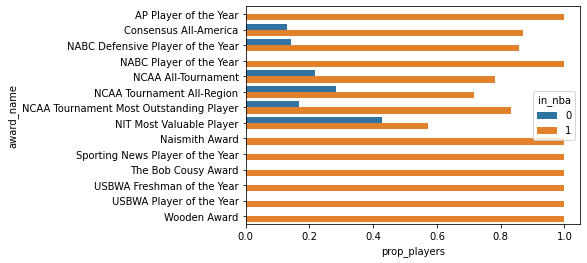

In [236]:
sns.barplot(data = x, x = 'prop_players', y = 'award_name', hue = 'in_nba')

On the one hand, from this chart we can see that winning any of these awards is your golden ticket to the big league. At the same time, these results should not be that surprising given that each of these awards are won by just 1 player out of (potentially) 10,000+ players. So if you are one of the best players in the country in a given year, you are almost guaranteed a spot in the NBA draft. 

In [238]:
df[df.award_category_l3=='Individual'].groupby(['award_name'])['cbb_player_id'].nunique()

award_name
AP Player of the Year                        7
Consensus All-America                       58
NABC Defensive Player of the Year            6
NABC Player of the Year                      6
NCAA All-Tournament                         31
NCAA Tournament All-Region                 103
NCAA Tournament Most Outstanding Player      6
NIT Most Valuable Player                     7
Naismith Award                               7
Sporting News Player of the Year             7
The Bob Cousy Award                          7
USBWA Freshman of the Year                   6
USBWA Player of the Year                     7
Wooden Award                                 7
Name: cbb_player_id, dtype: int64

## Applying market-basket analysis rules

In [241]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [242]:
z = df.copy()
z['val']=1
z = z.loc[(z.award_category_l3=='Individual'),['award_year_main','cbb_player_id','award_name','val']].pivot_table(index = ['award_year_main','cbb_player_id'],columns = 'award_name')
z.columns = z.columns.get_level_values(1)
# z.reset_index(inplace = True)
z.fillna(value = 0,inplace=True)
z.head(4)

award_name                         AP Player of the Year  \
award_year_main cbb_player_id                              
2011.0          brandon-knight-1                     0.0   
                harrison-barnes-1                    0.0   
                jared-sullinger-1                    0.0   
                jeremy-lamb-1                        0.0   

award_name                         Consensus All-America  \
award_year_main cbb_player_id                              
2011.0          brandon-knight-1                     0.0   
                harrison-barnes-1                    0.0   
                jared-sullinger-1                    1.0   
                jeremy-lamb-1                        0.0   

award_name                         NABC Defensive Player of the Year  \
award_year_main cbb_player_id                                          
2011.0          brandon-knight-1                                 0.0   
                harrison-barnes-1                                0.0   
                jared-sullinger-1                                0.0   
                jeremy-lamb-1                                    0.0   

award_name                         NABC Player of the Year  \
award_year_main cbb_player_id                                
2011.0          brandon-knight-1                       0.0   
                harrison-barnes-1                      0.0   
                jared-sullinger-1                      0.0   
                jeremy-lamb-1                          0.0   

award_name                         NCAA All-Tournament  \
award_year_main cbb_player_id                            
2011.0          brandon-knight-1                   0.0   
                harrison-barnes-1                  0.0   
                jared-sullinger-1                  0.0   
                jeremy-lamb-1                      1.0   

award_name                         NCAA Tournament All-Region  \
award_year_main cbb_player_id                                   
2011.0          brandon-knight-1                          1.0   
                harrison-barnes-1                         1.0   
                jared-sullinger-1                         0.0   
                jeremy-lamb-1                             1.0   

award_name                         NCAA Tournament Most Outstanding Player  \
award_year_main cbb_player_id                                                
2011.0          brandon-knight-1                                       0.0   
                harrison-barnes-1                                      0.0   
                jared-sullinger-1                                      0.0   
                jeremy-lamb-1                                          0.0   

award_name                         NIT Most Valuable Player  Naismith Award  \
award_year_main cbb_player_id                                                 
2011.0          brandon-knight-1                        0.0             0.0   
                harrison-barnes-1                       0.0             0.0   
                jared-sullinger-1                       0.0             0.0   
                jeremy-lamb-1                           0.0             0.0   

award_name                         Sporting News Player of the Year  \
award_year_main cbb_player_id                                         
2011.0          brandon-knight-1                                0.0   
                harrison-barnes-1                               0.0   
                jared-sullinger-1                               0.0   
                jeremy-lamb-1                                   0.0   

award_name                         The Bob Cousy Award  \
award_year_main cbb_player_id                            
2011.0          brandon-knight-1                   0.0   
                harrison-barnes-1                  0.0   
                jared-sullinger-1                  0.0   
                jeremy-lamb-1                      0.0   

award_name  

In [381]:
itemsets = apriori(z, min_support=0.001, use_colnames = True)

In [382]:
rules = association_rules(itemsets, metric = 'lift', min_threshold = 0.5)
rules['antec_length'] = rules.antecedents.apply(lambda x: len(x))
rules['conse_length'] = rules.consequents.apply(lambda x: len(x))

# unpack from frozenset
rules['antecedents_str'] = rules.antecedents.astype('str')
rules['consequents_str'] = rules.consequents.astype('str')

rules['antecedents_str'] = rules['antecedents_str'].str.removeprefix("frozenset({")
rules['antecedents_str'] = rules['antecedents_str'].str.removesuffix("})")

rules['consequents_str'] = rules['consequents_str'].str.removeprefix("frozenset({")
rules['consequents_str'] = rules['consequents_str'].str.removesuffix("})")

rules['antecedents_str'] = rules['antecedents_str'].str.replace("'",'')
rules['consequents_str'] = rules['consequents_str'].str.replace("'",'')

rules.sort_values('lift', ascending = False).head(3)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antec_length,conse_length,antecedents_str,consequents_str
131642,"(AP Player of the Year, USBWA Freshman of the Year)","(Wooden Award, NABC Defensive Player of the Year, Naismith Award, Sporting News Player of the Year, Consensus All-America, NCAA All-Tournament)",0.005952,0.005952,0.005952,1.0,168.0,0.005917,inf,2,6,"AP Player of the Year, USBWA Freshman of the Year","Wooden Award, NABC Defensive Player of the Year, Naismith Award, Sporting News Player of the Year, Consensus All-America, NCAA All-Tournament"
162941,"(NABC Defensive Player of the Year, Sporting News Player of the Year, NCAA Tournament All-Region, Consensus All-America, NCAA All-Tournament, USBWA Freshman of the Year)","(Naismith Award, NCAA Tournament Most Outstanding Player)",0.005952,0.005952,0.005952,1.0,168.0,0.005917,inf,6,2,"NABC Defensive Player of the Year, Sporting News Player of the Year, NCAA Tournament All-Region, Consensus All-America, NCAA All-Tournament, USBWA Freshman of the Year","Naismith Award, NCAA Tournament Most Outstanding Player"
210059,"(AP Player of the Year, Naismith Award, USBWA Player of the Year, Consensus All-America, NABC Defensive Player of the Year, USBWA Freshman of the Year)","(NCAA All-Tournament, Sporting News Player of the Year, NCAA Tournament All-Region, NCAA Tournament Most Outstanding Player)",0.005952,0.005952,0.005952,1.0,168.0,0.005917,inf,6,4,"AP Player of the Year, Naismith Award, USBWA Player of the Year, Consensus All-America, NABC Defensive Player of the Year, USBWA Freshman of the Year","NCAA All-Tournament, Sporting News Player of the Year, NCAA Tournament All-Region, NCAA Tournament Most Outstanding Player"


There are some awards which come in groups:  
Winning a Wooden award will give you 85% chance to take home AP POY, USBWA POY, Consensus All-American and Naismith.

In [383]:
x = rules.loc[(rules.antec_length==1)&(rules.conse_length==1)&
              (~rules.antecedents_str.isin(['Consensus All-America','NCAA All-Tournament','NCAA Tournament All-Region']))&
              (~rules.consequents_str.isin(['Consensus All-America','NCAA All-Tournament','NCAA Tournament All-Region'])),
              ['antecedents_str','consequents_str','confidence']]

x.head()

,antecedents_str,consequents_str,confidence
2,NABC Defensive Player of the Year,AP Player of the Year,0.142857
3,AP Player of the Year,NABC Defensive Player of the Year,0.142857
4,AP Player of the Year,NABC Player of the Year,0.857143
5,NABC Player of the Year,AP Player of the Year,1.000000
10,AP Player of the Year,NCAA Tournament Most Outstanding Player,0.142857


In [385]:
rules[rules.antecedents_str.str.contains('Def', regex = False)].head()
# rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antec_length,conse_length,antecedents_str,consequents_str
2,(NABC Defensive Player of the Year),(AP Player of the Year),0.041667,0.041667,0.005952,0.142857,3.428571,0.004216,1.118056,1,1,NABC Defensive Player of the Year,AP Player of the Year
24,(NABC Defensive Player of the Year),(Consensus All-America),0.041667,0.369048,0.029762,0.714286,1.935484,0.014385,2.208333,1,1,NABC Defensive Player of the Year,Consensus All-America
46,(NABC Defensive Player of the Year),(NCAA All-Tournament),0.041667,0.190476,0.005952,0.142857,0.750000,-0.001984,0.944444,1,1,NABC Defensive Player of the Year,NCAA All-Tournament
48,(NABC Defensive Player of the Year),(NCAA Tournament Most Outstanding Player),0.041667,0.035714,0.005952,0.142857,4.000000,0.004464,1.125000,1,1,NABC Defensive Player of the Year,NCAA Tournament Most Outstanding Player
50,(NABC Defensive Player of the Year),(Naismith Award),0.041667,0.041667,0.005952,0.142857,3.428571,0.004216,1.118056,1,1,NABC Defensive Player of the Year,Naismith Award


In [386]:
y

consequents_str,AP Player of the Year,NABC Player of the Year,Naismith Award,Sporting News Player of the Year,USBWA Player of the Year,Wooden Award
antecedents_str,,,,,,
AP Player of the Year,0.000000,0.857143,0.857143,0.000000,0.857143,0.857143
NABC Player of the Year,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Naismith Award,0.857143,0.000000,0.000000,0.857143,1.000000,1.000000
Sporting News Player of the Year,0.000000,0.000000,0.857143,0.000000,0.857143,0.857143
USBWA Player of the Year,0.857143,0.000000,1.000000,0.857143,0.000000,1.000000
Wooden Award,0.857143,0.000000,1.000000,0.857143,1.000000,0.000000


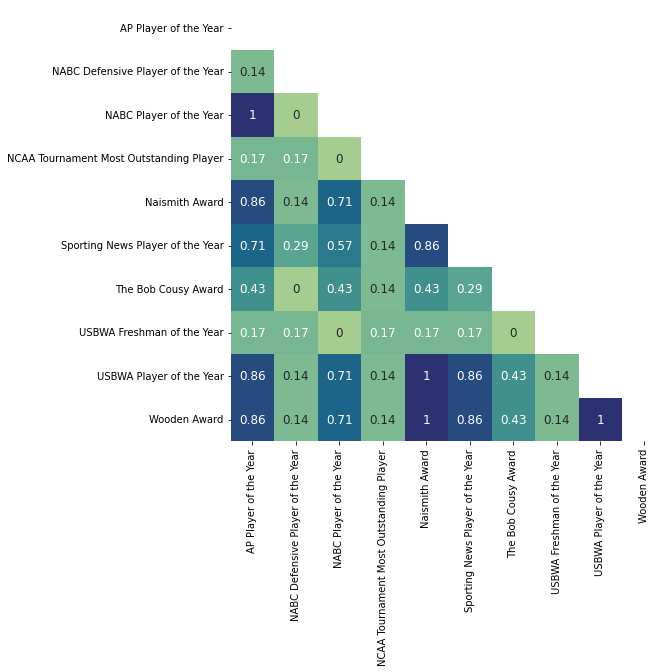

In [387]:
y = x.pivot(index = 'antecedents_str', columns = 'consequents_str', values = 'confidence')
y.fillna(0,inplace = True)
mask = np.zeros_like(y)
mask[np.triu_indices_from(mask)]=True
cmap = sns.color_palette("crest", as_cmap=True)
plt.figure(figsize=(8,8))
g = sns.heatmap(y, mask=mask, vmax=1, square=True, annot = True, cmap = cmap, annot_kws = {'size':12},cbar = False)
g.set_xlabel('')
g.set_ylabel('')
plt.show()

An interesting insight would be to see if these awards are truly different or do they rewards the same type of performance. In other words, does winning one award guarantee winning another?  
If we try to do this analysis manually it would become very tricky. Essentially what we want to know is whether for a given year does one player win the same multiple awards. If abstract the problem by removing awards and just think about it as a general concepts, what we want to know is {when A} ==> {then B}. This is actually a Market Basket Analysis.  
Running this problem as a Market Basket Analysis gives us some interesting information, however we don't really have enough data here to be able to make any serious conclusions. For example, we cannot say which award leads to which other award. However what we can get is the 'confidence' between two awards. This will tell us the proportion of times a player who receives one award will also get another.  

Applying a bit of manipulation to the data and plotting it on a heat-map we get exactly what we want.  
There are definitely some awards that seems to be given together. For example, Naismith and Wooden awards appear to be won by the same player every year over the 9 years (different player each time). 
Most awards are won in pairs some of time. The only type of awards that are not won together are those that are biased towards playing position and/or player's class (Freshmen, Sophomore etc). For example The Bob Cousy awards is give to a player who plays the point guard position where as Defensive POY  

In [978]:
# x = df.loc[:,['cbb_player_id','in_nba','total_seasons','award_name','award_category_l1','award_category_l2','award_category_l3','conf_abbr','award_yr_fr_flag','award_yr_so_flag','award_yr_jr_flag','award_yr_sr_flag']]
x = df.melt(id_vars = ['cbb_player_id','main_conf','in_nba','total_seasons','award_won_fist_year','award_won_last_year','award_year_main','award_name','award_category_l1','award_category_l2','award_category_l3','conf_abbr'],value_vars = ['award_yr_fr_flag','award_yr_so_flag','award_yr_jr_flag','award_yr_sr_flag'])
x = x.loc[x.value ==1,:].rename(columns = {'variable':'award_year_flag'}).drop(columns = 'value')
x['award_year_flag'] = x.award_year_flag.str.replace('award_yr_fr_flag','fr').replace('award_yr_so_flag','so').replace('award_yr_jr_flag','jr').replace('award_yr_sr_flag','sr')
x_group = x.groupby(['cbb_player_id','in_nba','main_conf','total_seasons','award_won_fist_year','award_won_last_year','award_category_l3','award_year_flag'])['award_name'].count().reset_index().rename(columns = {'award_name':'total_awards'})
x_group.loc[(x_group.award_year_flag=='fr')&(x_group.award_category_l3=='Conference'),'avail_awards'] = 6
x_group.loc[(x_group.award_year_flag!='fr')&(x_group.award_category_l3=='Conference'),'avail_awards'] = 5
x_group.loc[x_group.award_category_l3=='Individual','avail_awards'] = 15
x_group['perc_awards_won'] = x_group.total_awards/x_group.avail_awards
x_group['l3_class_rank'] = x_group.groupby(['award_category_l3','award_year_flag'])['perc_awards_won'].rank(method = 'first', ascending = False)
x_group.head(2)

,cbb_player_id,in_nba,main_conf,total_seasons,award_won_fist_year,award_won_last_year,award_category_l3,award_year_flag,total_awards,avail_awards,perc_awards_won,l3_class_rank
0,aaron-anderson-3,0,big-sky,4,0,0,Conference,jr,1,5.0,0.2,106.0
1,aaron-anderson-3,0,big-sky,4,0,1,Conference,sr,1,5.0,0.2,226.0


#### overall total awards

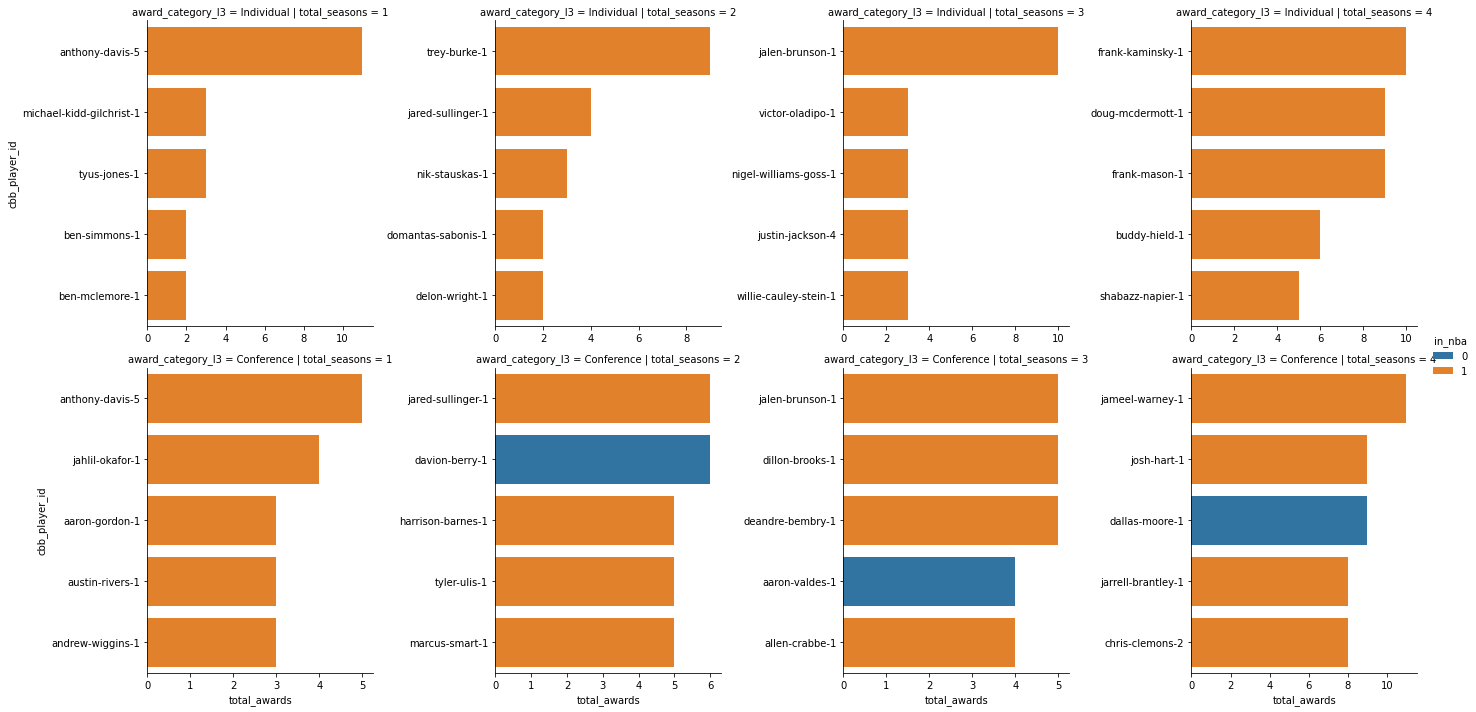

In [979]:
# top 5 players for each award category
z = x.groupby(['cbb_player_id','in_nba','main_conf','total_seasons','award_category_l3'])['award_name'].count().reset_index().rename(columns = {'award_name':'total_awards'})
z.head()
z['rank_l3'] = z.groupby(['award_category_l3','total_seasons'])['total_awards'].rank(method = 'first', ascending = False)

sns.catplot(data = z[z.rank_l3<=5].sort_values(by = ['total_awards'], ascending = False), x = 'total_awards', y = 'cbb_player_id', row = 'award_category_l3',col = 'total_seasons',
            kind = 'bar', sharey = False, sharex = False,hue = 'in_nba', dodge = False)

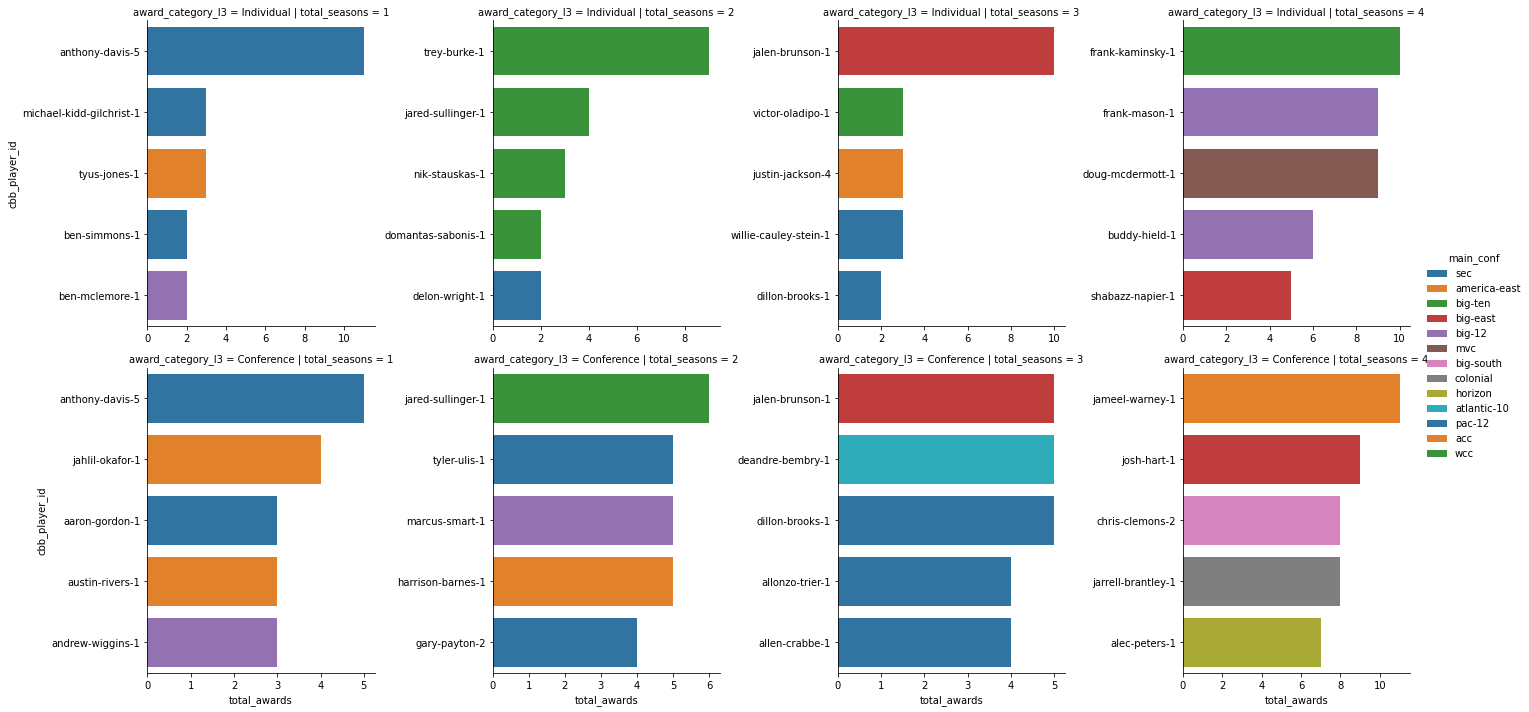

In [953]:
# player with most awards  in NBA
z = x[x.in_nba==1].groupby(['cbb_player_id','in_nba','main_conf','total_seasons','award_category_l3'])['award_name'].count().reset_index().rename(columns = {'award_name':'total_awards'})
z['rank_l3'] = z.groupby(['award_category_l3','total_seasons'])['total_awards'].rank(method = 'first', ascending = False)

sns.catplot(data = z[z.rank_l3<=5].sort_values(by = ['total_awards'], ascending = False), x = 'total_awards', y = 'cbb_player_id', row = 'award_category_l3', col = 'total_seasons', kind = 'bar',
            sharey = False,sharex=False, hue = 'main_conf',dodge = False, palette = 'tab10')

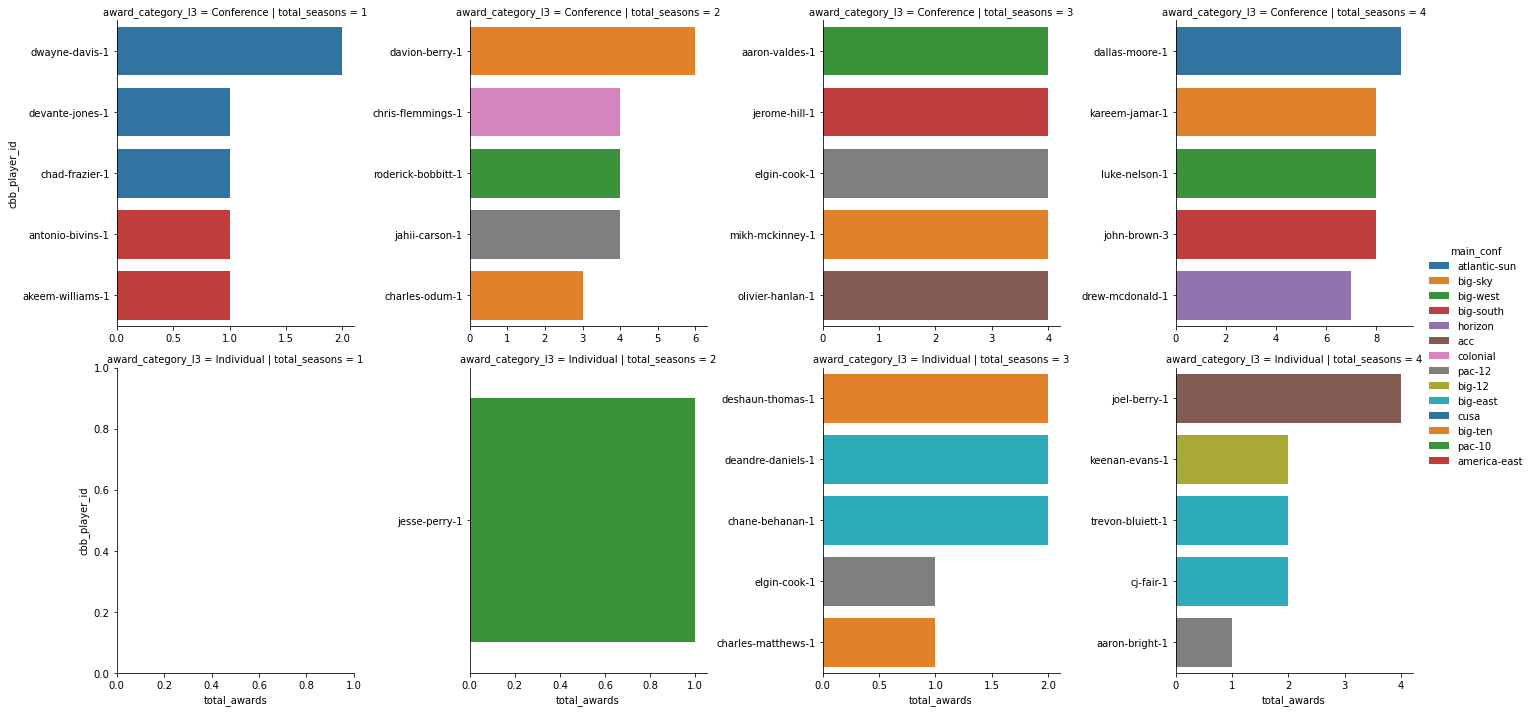

In [931]:
# player with most awards not in NBA
z = x[x.in_nba==0].groupby(['cbb_player_id','in_nba','main_conf','total_seasons','award_category_l3'])['award_name'].count().reset_index().rename(columns = {'award_name':'total_awards'})
z['rank_l3'] = z.groupby(['award_category_l3','total_seasons'])['total_awards'].rank(method = 'first', ascending = False)

sns.catplot(data = z[z.rank_l3<=5].sort_values(by = ['total_awards'], ascending = False), x = 'total_awards', y = 'cbb_player_id', row = 'award_category_l3', col = 'total_seasons', kind = 'bar',
            sharey = False,sharex=False, hue = 'main_conf',dodge = False, palette = 'tab10')

In [ ]:
# number of players without any awards in the nba
# player with most awards not in NBA
z = x[(x.in_nba==1)&(x.)].groupby(['cbb_player_id','in_nba','main_conf','total_seasons','award_category_l3'])['award_name'].count().reset_index().rename(columns = {'award_name':'total_awards'})
z['rank_l3'] = z.groupby(['award_category_l3','total_seasons'])['total_awards'].rank(method = 'first', ascending = False)

sns.catplot(data = z[z.rank_l3<=5].sort_values(by = ['total_awards'], ascending = False), x = 'total_awards', y = 'cbb_player_id', row = 'award_category_l3', col = 'total_seasons', kind = 'bar',
            sharey = False,sharex=False, hue = 'main_conf',dodge = False, palette = 'tab10')

In [995]:
df['any_award_flag'] = np.where(df.award_name.isna(),0,1)

<AxesSubplot:xlabel='any_award_flag', ylabel='total_players'>

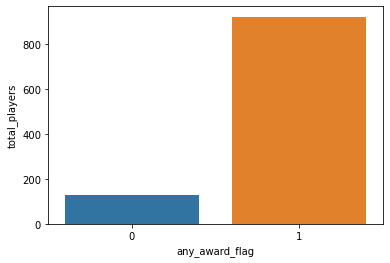

In [1019]:
z = df[df.in_nba==1].groupby(['any_award_flag'])['cbb_player_id'].count().reset_index().rename(columns = {'cbb_player_id':'total_players'})
sns.barplot(data = z, x = 'any_award_flag',y = 'total_players')

In [1000]:
df[(df.any_award_flag==0)&(df.in_nba==1)].shape

(130, 35)

In [986]:
df[(df.award_yr_fr_flag + df.award_yr_so_flag + df.award_yr_jr_flag + df.award_yr_sr_flag ==0)].head()

,cbb_player_id,name,nba_player_id,in_nba,first_year,last_year,no_conf,total_seasons,award_orig_name,award_name,award_category_l1,award_category_l2,award_category_l3,conf_abbr,conf_full,short_name,award_year_main,use_for_analysis,pick,d_year,d_round,d_class,height_cm,main_conf,award_yr_fr,award_yr_so,award_yr_jr,award_yr_sr,award_yr_fr_flag,award_yr_so_flag,award_yr_jr_flag,award_yr_sr_flag,award_won_fist_year,award_won_last_year
0,harrison-hawkins-1,Harrison Hawkins,NaN,0,2013,2014,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,183.0,southland,NaN,NaN,NaN,NaN,0,0,0,0,0,0
1,parker-wentz-1,Parker Wentz,NaN,0,2013,2015,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,175.0,southland,NaN,NaN,NaN,NaN,0,0,0,0,0,0
2,ladarrien-williams-1,LaDarrien Williams,NaN,0,2013,2014,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,183.0,southland,NaN,NaN,NaN,NaN,0,0,0,0,0,0
3,austin-cooke-1,Austin Cooke,NaN,0,2013,2015,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,201.0,southland,NaN,NaN,NaN,NaN,0,0,0,0,0,0
4,duran-porter-1,Duran Porter,NaN,0,2014,2015,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,southland,NaN,NaN,NaN,NaN,0,0,0,0,0,0


### Conference Analysis

<AxesSubplot:xlabel='total_awards', ylabel='main_conf'>

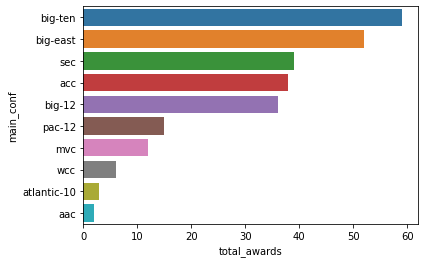

In [666]:
# top conferences for individual awards
z = x.groupby(['main_conf','award_category_l3'])['award_name'].count().reset_index().rename(columns = {'award_name':'total_awards'})
z['rank_l3'] = z.groupby(['award_category_l3'])['total_awards'].rank(method = 'first', ascending = False)
z['awards_cumulative'] = z[z.award_category_l3 == 'Individual'].sort_values('rank_l3').total_awards.cumsum()/z[z.award_category_l3 == 'Individual'].total_awards.sum()
sns.barplot(data = z[(z.rank_l3<=10) & (z.award_category_l3 == 'Individual')].sort_values(by = ['total_awards'], ascending = False), x = 'total_awards', y = 'main_conf')

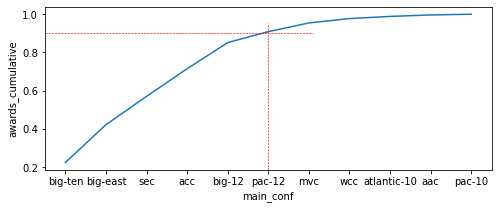

In [707]:
plt.figure(figsize = (8,3))
g = sns.lineplot(data = z[z.award_category_l3=='Individual'].sort_values('rank_l3'), x = 'main_conf', y = 'awards_cumulative',sort = False )
g.axvline(x=5, ymax = .9,ls ='--',color = 'red',lw=.6)
g.axhline(y = 0.9, xmax = .6, ls = '--', color = 'red', lw = .6)

90% of all Individual awards are won by just 6 conferences

## Other analysis

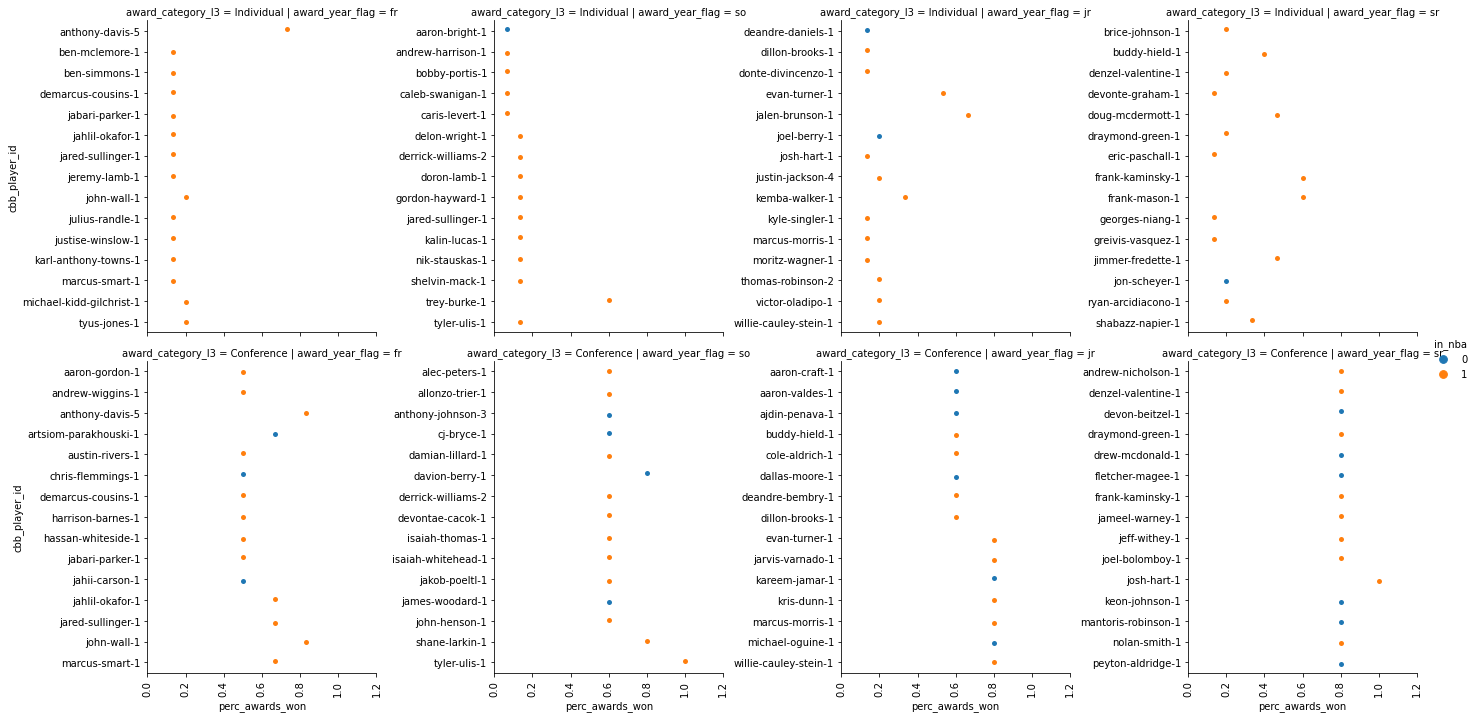

In [200]:
g = sns.catplot(data = x_group[x_group.l3_class_rank <=15], y = 'cbb_player_id',x = 'perc_awards_won', col = 'award_year_flag',row = 'award_category_l3',sharey=False,
                col_order = ['fr','so','jr','sr'],
                hue = 'in_nba'
               )
g.set_xticklabels(rotation = 90)

#### Percentage of available awards won by Conference and Class. Top 15
Interesting when looking at individual players. Need to see this a whole across larger sample

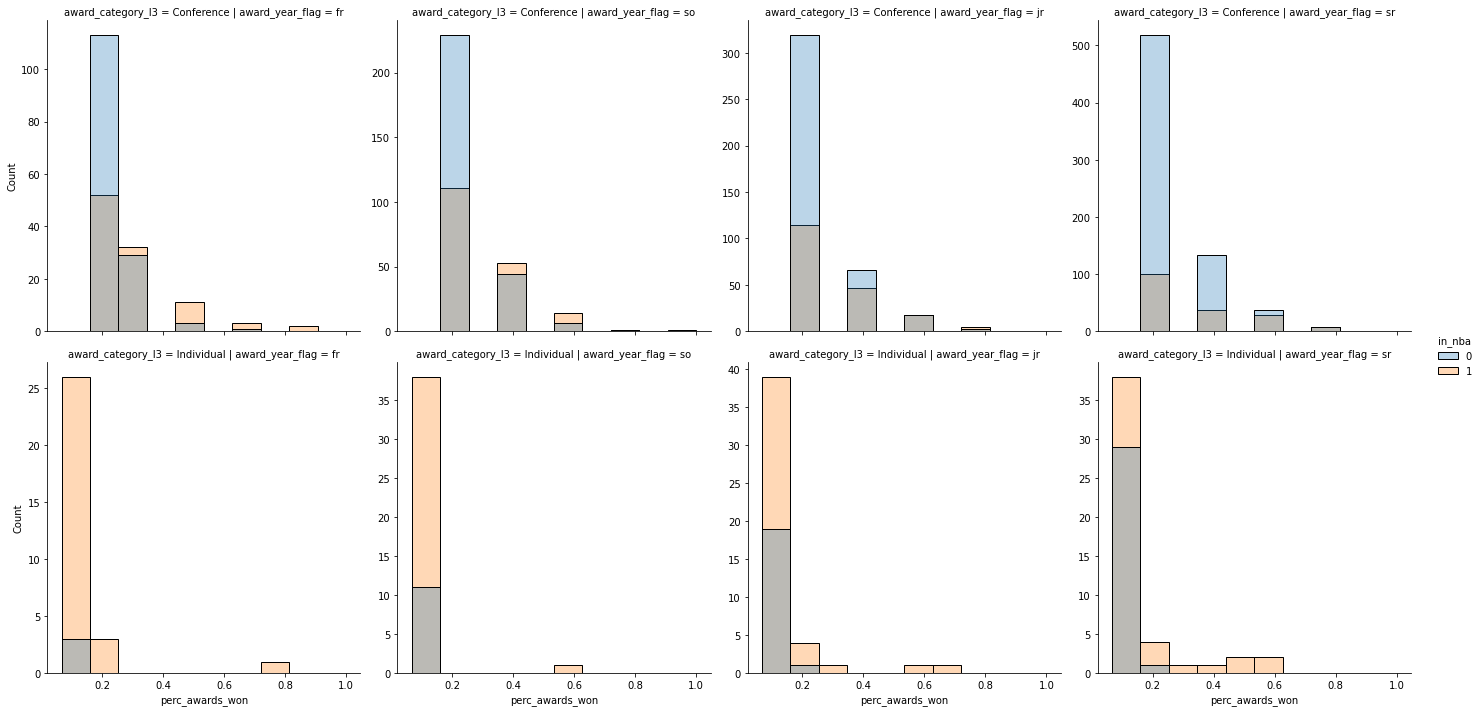

In [276]:
sns.displot(data = x_group[x_group.total_awards>0], x = 'perc_awards_won',col = 'award_year_flag',row = 'award_category_l3',facet_kws=dict(sharey=False),bins = 10,col_order = ['fr','so','jr','sr'],
            hue = 'in_nba',
            alpha = 0.3
           )

**Conference award:**  
**Individual award:** Winning in the Fr year seems to correlate strongly with NBA, while in Sr, not so much

#### looking at accumulated awards over the years by class
total awards Fr, Total awards Fr+So etc

In [407]:


# fr group
fr = x_group[(x_group.award_year_flag.isin(['fr']))&(x_group.total_seasons == 1)].groupby(['cbb_player_id','in_nba','award_category_l3'])\
.agg(
    cum_awards = ('total_awards','sum'),
    cum_avail_awards = ('avail_awards','sum')
).reset_index()
fr['group_name'] = 'fr'

# fr_so group
fr_so = x_group[(x_group.award_year_flag.isin(['fr','so']))&(x_group.total_seasons == 2)].groupby(['cbb_player_id','in_nba','award_category_l3'])\
.agg(
    cum_awards = ('total_awards','sum'),
    cum_avail_awards = ('avail_awards','sum')
).reset_index()
fr_so['group_name'] = 'fr_so'

# fr_so_jr group
fr_so_jr = x_group[(x_group.award_year_flag.isin(['fr','so','jr']))&(x_group.total_seasons == 3)].groupby(['cbb_player_id','in_nba','award_category_l3'])\
.agg(
    cum_awards = ('total_awards','sum'),
    cum_avail_awards = ('avail_awards','sum')
).reset_index()
fr_so_jr['group_name'] = 'fr_so_jr'

# fr_so_jr_sr group
fr_so_jr_sr = x_group[(x_group.award_year_flag.isin(['fr','so','jr','sr']))&(x_group.total_seasons == 4)].groupby(['cbb_player_id','in_nba','award_category_l3'])\
.agg(
    cum_awards = ('total_awards','sum'),
    cum_avail_awards = ('avail_awards','sum')
).reset_index()
fr_so_jr_sr['group_name'] = 'fr_so_jr_sr'

# concatenate groups
cum_awards = pd.concat([fr,fr_so,fr_so_jr,fr_so_jr_sr], axis = 0)
cum_awards['perc_awards_won'] = cum_awards.cum_awards/cum_awards.cum_avail_awards
cum_awards['l3_class_rank'] = cum_awards.groupby(['award_category_l3','group_name'])['perc_awards_won'].rank(method = 'first', ascending = False)
cum_awards.head()

,cbb_player_id,in_nba,award_category_l3,cum_awards,cum_avail_awards,group_name,perc_awards_won,l3_class_rank
0,aaron-gordon-1,1,Conference,3,6.0,fr,0.500000,4.0
1,aaron-gordon-1,1,Individual,1,15.0,fr,0.066667,13.0
2,akeem-williams-1,0,Conference,1,6.0,fr,0.166667,30.0
3,andrew-wiggins-1,1,Conference,3,6.0,fr,0.500000,5.0
4,andrew-wiggins-1,1,Individual,1,15.0,fr,0.066667,14.0


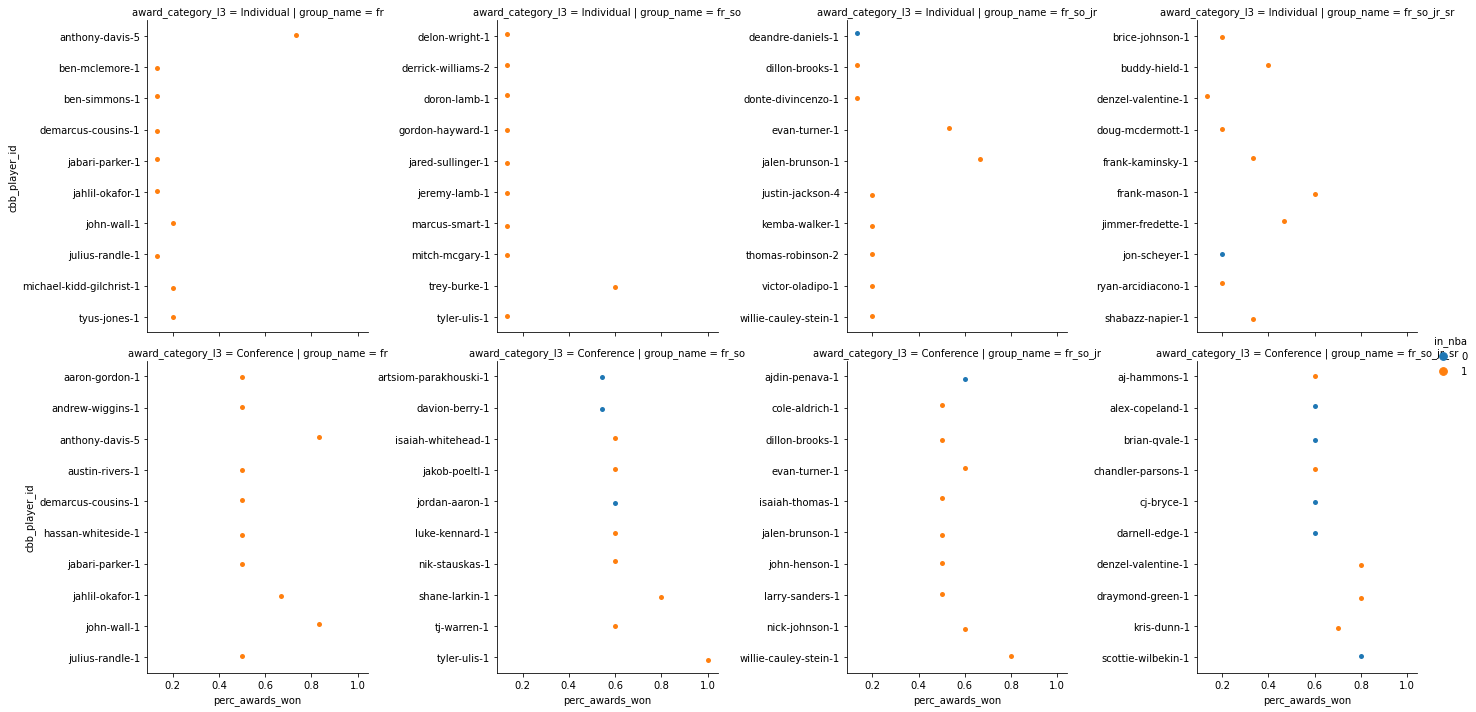

In [413]:
sns.catplot(data = cum_awards[(cum_awards.l3_class_rank<=10)], x = 'perc_awards_won', y = 'cbb_player_id', col = 'group_name',row = 'award_category_l3',height = 5, sharey=False, hue = 'in_nba',
           row_order = ['Individual','Conference'])

wall and AD seems to be on top but they are both Fr class. 
need to have player/class vs number of awards

Storyline???  
we know that there is a very strong correlation between number of awards and being in NBA. awards are like a measuaring stick. if you win many awards, especially Individual types then you are the best college player and will get a chance in the NBA.  
the above categorical charts would be good if you are interested in specific players. it's not very good at seeing patterns overall.

i can show that those who win awards are more likely to be in NBA.  
the relationship seems to be stronger with individual awards, which make sense since winning those makes you the best of the best  
I can also link award+conf to nba. 
number of player without awards in nba
number of players without Indiv awards in nba
number of players without Conf awards in nba

player with most awards who is not in nba - all awards, conf, individual

waiting until a player wins the award before declaring for the draft???
- winning award & final year

In [499]:
# proportion/number of players who win varios awards in their last year
z = x.groupby(['award_category_l1','award_category_l2','award_won_last_year'])['award_name'].count().reset_index().rename(columns = {'award_name':'total_awards_fist_year'})
y = z.groupby(['award_category_l1','award_category_l2'])['total_awards_fist_year'].sum().reset_index().rename(columns = {'total_awards_fist_year':'total_awards'})
z = z.merge(y, how = 'inner', left_on=['award_category_l1','award_category_l2'],right_on=['award_category_l1','award_category_l2'])
z['prop'] = z.total_awards_fist_year/z.total_awards
z

,award_category_l1,award_category_l2,award_won_last_year,total_awards_fist_year,total_awards,prop
0,Conference Award,All-Conf,0,793,1614,0.491326
1,Conference Award,All-Conf,1,821,1614,0.508674
2,Conference Award,All-Conf Tourney,0,346,686,0.504373
3,Conference Award,All-Conf Tourney,1,340,686,0.495627
4,Conference Award,DPOY,0,61,150,0.406667
5,Conference Award,DPOY,1,89,150,0.593333
6,Conference Award,POY,0,84,269,0.312268
7,Conference Award,POY,1,185,269,0.687732
8,Conference Award,ROY,0,108,135,0.800000
9,Conference Award,ROY,1,27,135,0.200000


**Question:** For how many players is their last season not the Sr?

#### Awards by conference

In [546]:
a = x[x.award_category_l3 == 'Individual'].groupby(['award_name','main_conf'])['cbb_player_id'].count().reset_index().rename(columns = {'cbb_player_id':'total_awards'})
b = a.groupby(['award_name'])['total_awards'].transform('sum')

a['prop'] = a.total_awards/b
a.sort_values(['award_name','main_conf']).head(3)


,award_name,main_conf,total_awards,prop
0,AP Player of the Year,big-12,1,0.111111
1,AP Player of the Year,big-east,1,0.111111
2,AP Player of the Year,big-ten,4,0.444444


/Users/leo/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:3808: UserWarning: Setting `sharey=False` with `color=None` may cause different levels of the `y` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharey", "y"), UserWarning)


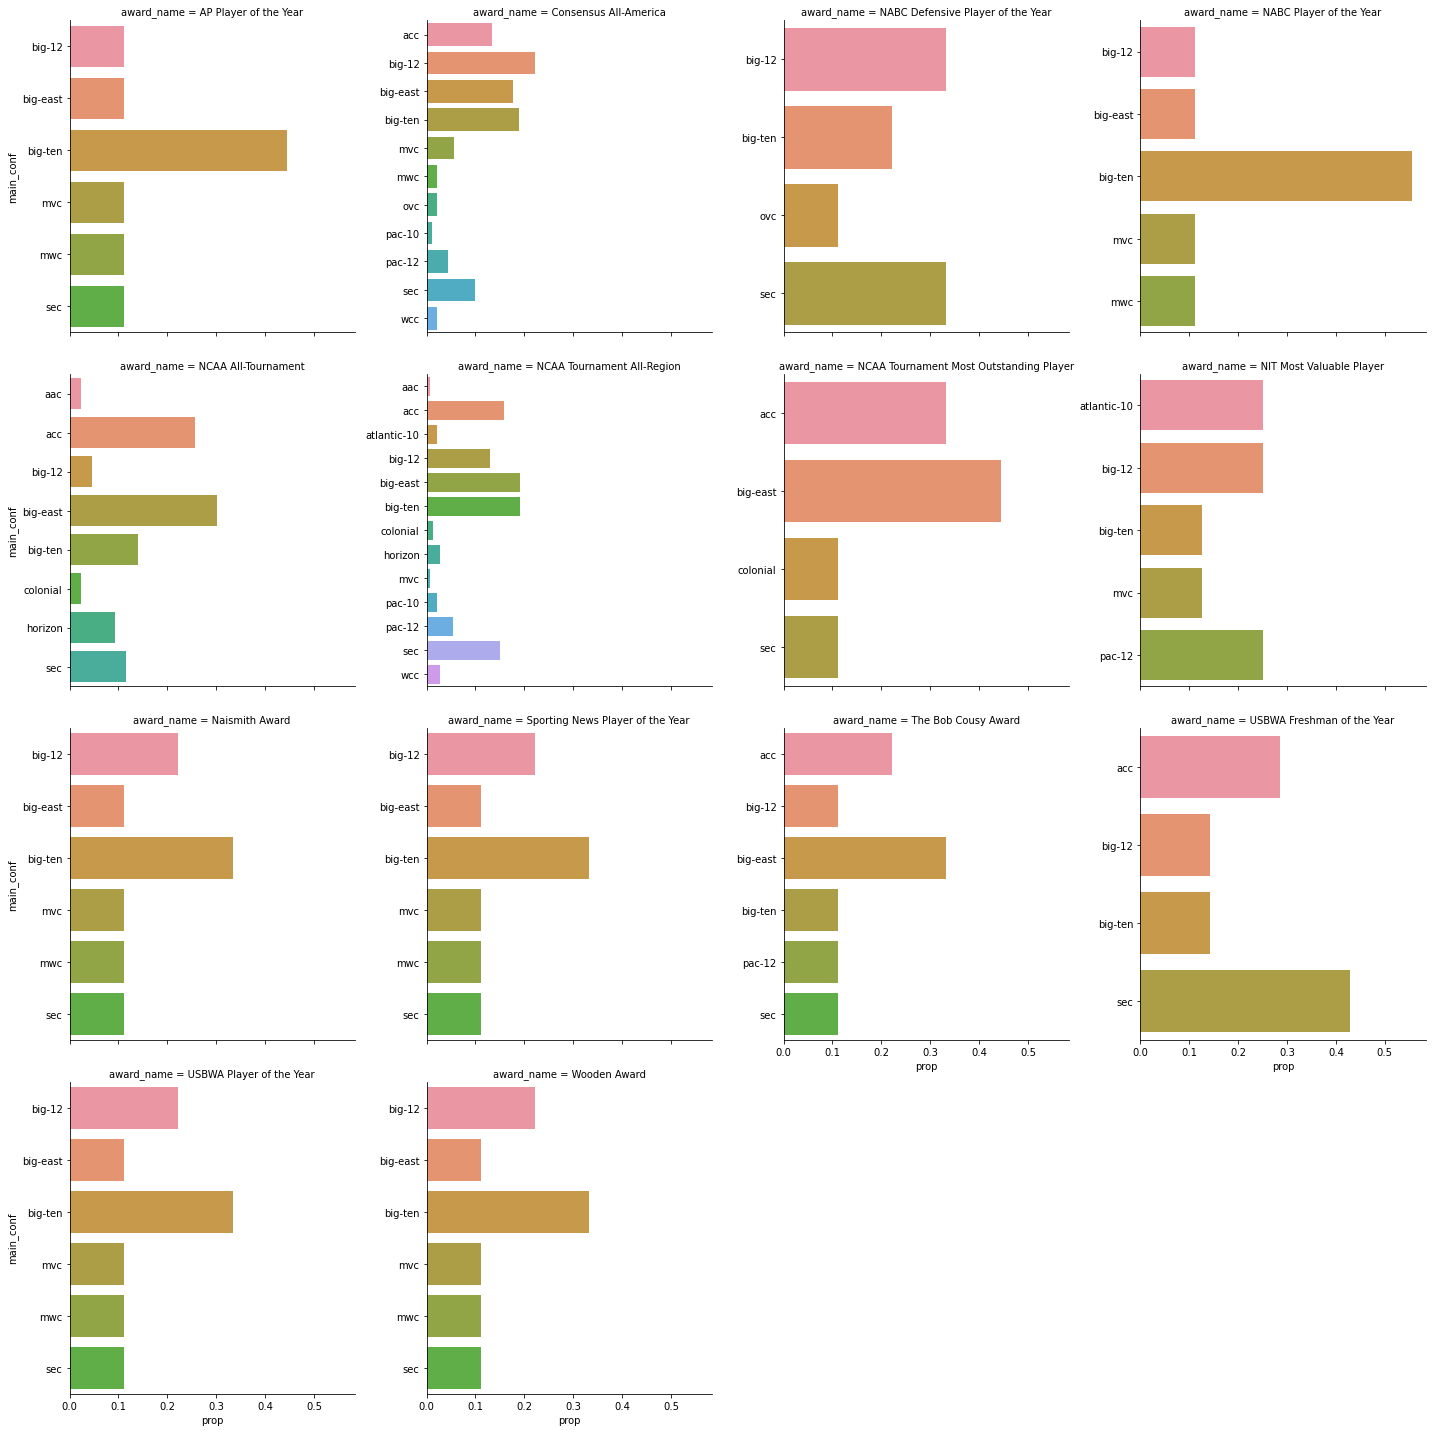

In [571]:
sns.catplot(data = a, x = 'prop', y = 'main_conf', col = 'award_name',col_wrap = 4, sharey = False, kind = 'bar')